In [ ]:
!nvidia-smi

Mon Sep 11 10:03:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip -u "/content/drive/MyDrive/Generative AI, from GANs to CLIP, with Python and Pytorch/Fadarate learning/Brain Tumor MRI Dataset.zip" -d "/content/"

print('\n\ndone!')

Streaming output truncated to the last 5000 lines.
  inflating: /content/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/Training/glioma/Tr-gl_0724.jpg  
  inflating: /content/Training/glioma/Tr-gl_0725.jpg  
  inflating: /content/Training/glioma/Tr-gl_0726.jpg  
  inflating: /content/Training/glioma/Tr-gl_0727.jpg  
  inflating: /content/Training/glioma/Tr-gl_0728.jpg  
  inflating: /content/Training/glioma/Tr-gl_0729.jpg  
  inflating: /content/Training/glioma/Tr-gl_0730.jpg  
  inflating: /content/Training/glioma/Tr-gl_0731.jpg  
  inflating: /

In [ ]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [ ]:
train_dir = '/content/Training/'
test_dir = '/content/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

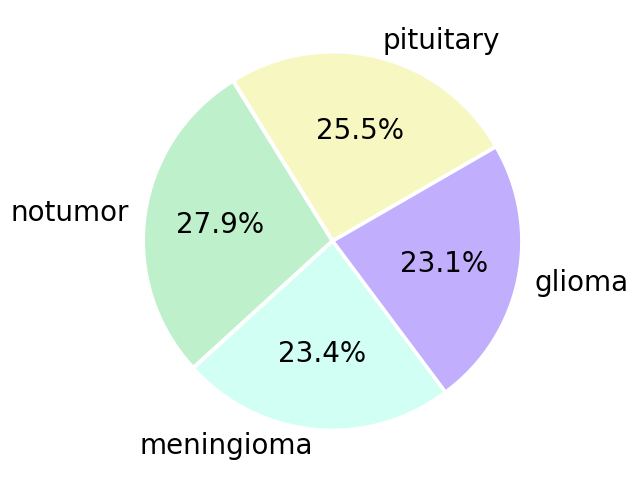

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#F6F7C1', '#BEF0CB', '#D1FFF3', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.015,0.015,0.015,0.015),
        startangle=30);

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

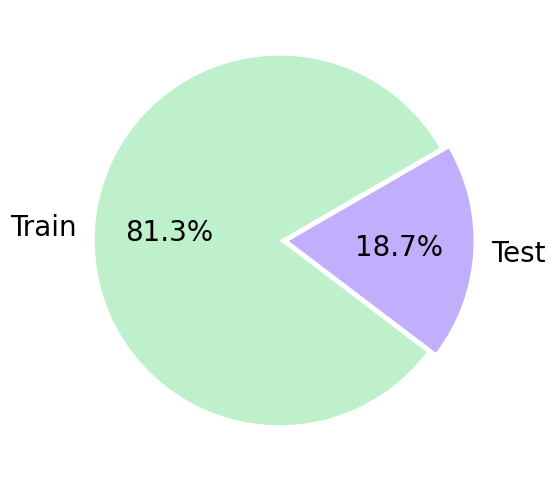

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#BEF0CB', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

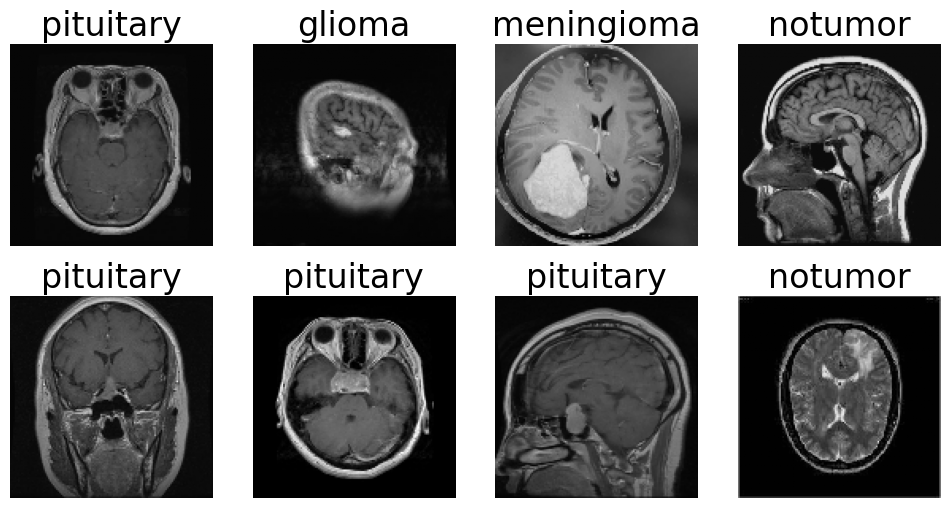

In [ ]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15763908 (60.13 MB)
Trainable params: 8128

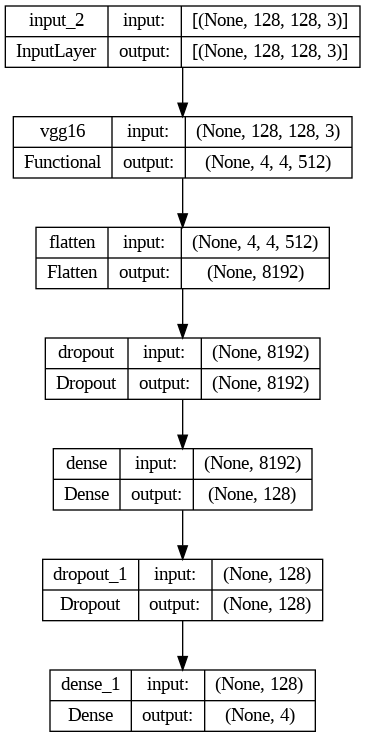

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
285/285 [==============================] - 34s 72ms/step - loss: 0.4490 - sparse_categorical_accuracy: 0.8230
Epoch 2/10
285/285 [==============================] - 22s 72ms/step - loss: 0.2387 - sparse_categorical_accuracy: 0.9113
Epoch 3/10
285/285 [==============================] - 18s 62ms/step - loss: 0.1557 - sparse_categorical_accuracy: 0.9378
Epoch 4/10
285/285 [==============================] - 17s 60ms/step - loss: 0.1184 - sparse_categorical_accuracy: 0.9541
Epoch 5/10
285/285 [==============================] - 17s 58ms/step - loss: 0.0842 - sparse_categorical_accuracy: 0.9689
Epoch 6/10
285/285 [==============================] - 17s 59ms/step - loss: 0.0612 - sparse_categorical_accuracy: 0.9768
Epoch 7/10
285/285 [==============================] - 18s 64ms/step - loss: 0.0573 - sparse_categorical_accuracy: 0.9812
Epoch 8/10
285/285 [==============================] - 17s 59ms/step - loss: 0.0456 - sparse_categorical_accuracy: 0.9835
Epoch 9/10
285/285 [============

# Federated Learning Based transfer Learning enabled VGG-16 Model

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 10
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

#     # Evaluate the global model
#     test_loss, test_acc = model.evaluate(test_paths, test_labels,)
#     print('Round {}: Test accuracy = {}'.format(round_num, test_acc))

# # Fine-tune the model
# model.fit(test_paths, test_labels, epochs=1, batch_size=32)

# Deploy the model
model.save('my_model.h5')

Epoch 1/5
28/28 [==============================] - 5s 63ms/step - loss: 0.0358 - sparse_categorical_accuracy: 0.9893
Epoch 2/5
28/28 [==============================] - 2s 51ms/step - loss: 0.0196 - sparse_categorical_accuracy: 0.9909
Epoch 3/5
28/28 [==============================] - 1s 54ms/step - loss: 0.0266 - sparse_categorical_accuracy: 0.9909
Epoch 4/5
28/28 [==============================] - 1s 54ms/step - loss: 0.0021 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
28/28 [==============================] - 1s 54ms/step - loss: 0.0239 - sparse_categorical_accuracy: 0.9946
Epoch 1/5
28/28 [==============================] - 4s 76ms/step - loss: 0.0468 - sparse_categorical_accuracy: 0.9893
Epoch 2/5
28/28 [==============================] - 2s 70ms/step - loss: 0.0224 - sparse_categorical_accuracy: 0.9927
Epoch 3/5
28/28 [==============================] - 2s 54ms/step - loss: 0.0112 - sparse_categorical_accuracy: 0.9964
Epoch 4/5
28/28 [==============================] - 2s 55ms/step 

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  2%|▎         | 1/40 [00:02<01:31,  2.34s/it]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 2/40 [00:02<00:39,  1.05s/it]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 3/40 [00:02<00:23,  1.58it/s]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 4/40 [00:02<00:17,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▎        | 5/40 [00:03<00:13,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 6/40 [00:03<00:10,  3.35it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 7/40 [00:03<00:08,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 8/40 [00:03<00:06,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 9/40 [00:03<00:06,  4.99it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 10/40 [00:03<00:05,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 11/40 [00:04<00:05,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 12/40 [00:04<00:04,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 13/40 [00:04<00:04,  5.80it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 14/40 [00:04<00:07,  3.36it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 15/40 [00:05<00:06,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 16/40 [00:05<00:05,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▎     | 17/40 [00:05<00:04,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 18/40 [00:05<00:04,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 19/40 [00:05<00:03,  5.27it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 20/40 [00:05<00:03,  5.53it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▎    | 21/40 [00:06<00:03,  5.63it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 22/40 [00:06<00:03,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▊    | 23/40 [00:06<00:02,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 24/40 [00:06<00:02,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▎   | 25/40 [00:06<00:02,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 26/40 [00:06<00:02,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 27/40 [00:07<00:02,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 28/40 [00:07<00:02,  5.43it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▎  | 29/40 [00:07<00:02,  5.07it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 30/40 [00:07<00:02,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 31/40 [00:07<00:01,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 32/40 [00:08<00:01,  4.70it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▎ | 33/40 [00:08<00:01,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 34/40 [00:08<00:01,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 35/40 [00:08<00:01,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 36/40 [00:09<00:00,  4.44it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▎| 37/40 [00:09<00:00,  4.45it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 38/40 [00:09<00:00,  4.42it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 39/40 [00:09<00:00,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


100%|██████████| 40/40 [00:10<00:00,  4.57it/s]

1/1 [==============================] - 2s 2s/step


41it [00:12,  3.31it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.96      0.95      0.96       300
  meningioma       0.95      0.95      0.95       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.98      0.99      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



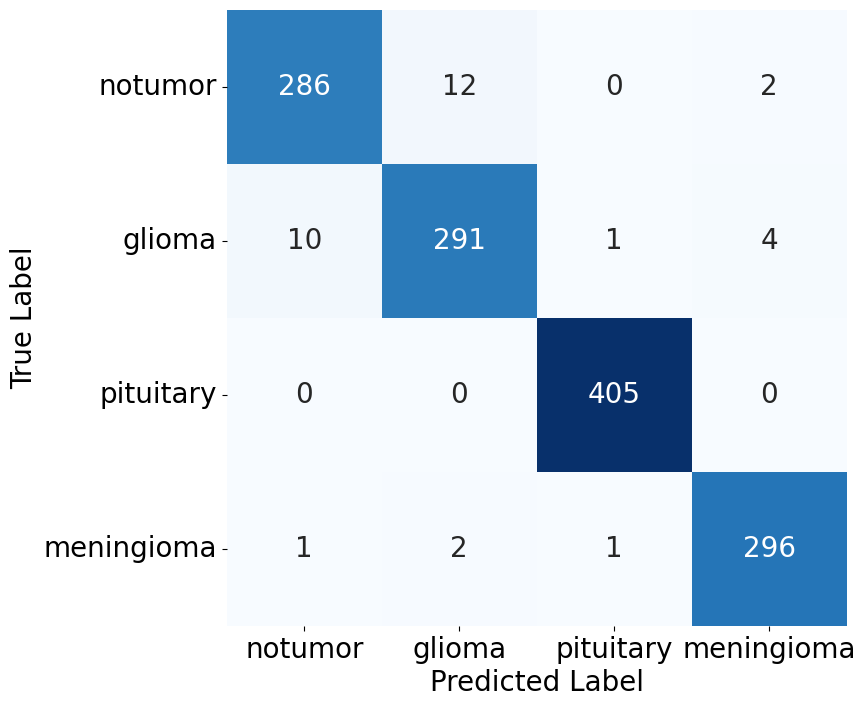

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()


# Improved Code of Transfer Learning Based VGG-16 Model

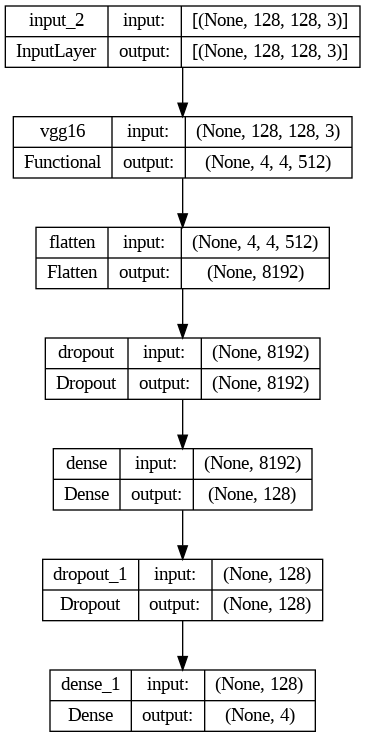

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
285/285 [==============================] - 19s 60ms/step - loss: 0.0457 - sparse_categorical_accuracy: 0.9872
Epoch 2/10
285/285 [==============================] - 17s 59ms/step - loss: 0.0229 - sparse_categorical_accuracy: 0.9940
Epoch 3/10
285/285 [==============================] - 18s 62ms/step - loss: 0.0312 - sparse_categorical_accuracy: 0.9896
Epoch 4/10
285/285 [==============================] - 17s 58ms/step - loss: 0.0289 - sparse_categorical_accuracy: 0.9935
Epoch 5/10
285/285 [==============================] - 16s 58ms/step - loss: 0.0298 - sparse_categorical_accuracy: 0.9884
Epoch 6/10
285/285 [==============================] - 16s 58ms/step - loss: 0.0096 - sparse_categorical_accuracy: 0.9963
Epoch 7/10
285/285 [==============================] - 17s 59ms/step - loss: 0.0141 - sparse_categorical_accuracy: 0.9954
Epoch 8/10
285/285 [==============================] - 18s 61ms/step - loss: 0.0449 - sparse_categorical_accuracy: 0.9888
Epoch 9/10
285/285 [============

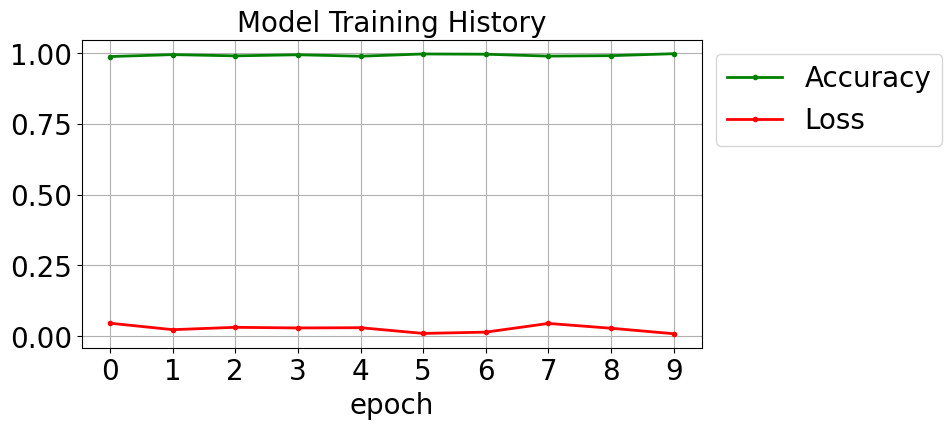

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History',fontsize =20)
plt.xlabel('epoch', fontsize =20)
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1), fontsize =20)
plt.show()

In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 155ms/step


  2%|▎         | 1/40 [00:00<00:11,  3.33it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 2/40 [00:00<00:08,  4.61it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 3/40 [00:00<00:07,  5.24it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 4/40 [00:00<00:06,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 5/40 [00:00<00:06,  5.67it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 6/40 [00:01<00:05,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 7/40 [00:01<00:05,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 8/40 [00:01<00:05,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 9/40 [00:01<00:05,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 10/40 [00:01<00:04,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 11/40 [00:01<00:04,  6.31it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 12/40 [00:02<00:04,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 13/40 [00:02<00:04,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 14/40 [00:02<00:04,  6.34it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 15/40 [00:02<00:03,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 16/40 [00:02<00:03,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▎     | 17/40 [00:02<00:03,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 18/40 [00:03<00:03,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 19/40 [00:03<00:03,  6.13it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 20/40 [00:03<00:03,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 21/40 [00:03<00:03,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 22/40 [00:03<00:02,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 23/40 [00:03<00:02,  6.24it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 24/40 [00:03<00:02,  6.28it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▎   | 25/40 [00:04<00:02,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 26/40 [00:04<00:02,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 27/40 [00:04<00:02,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 28/40 [00:04<00:02,  6.00it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▎  | 29/40 [00:04<00:01,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 30/40 [00:05<00:01,  5.81it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 31/40 [00:05<00:01,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 32/40 [00:05<00:01,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▎ | 33/40 [00:05<00:01,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 34/40 [00:05<00:01,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 35/40 [00:05<00:00,  5.88it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 36/40 [00:06<00:00,  5.97it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▎| 37/40 [00:06<00:00,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 38/40 [00:06<00:00,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 39/40 [00:06<00:00,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 40/40 [00:06<00:00,  5.93it/s]

1/1 [==============================] - 0s 145ms/step


41it [00:07,  5.85it/s]


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.99      0.96      0.97       300
  meningioma       0.95      0.99      0.97       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.98      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



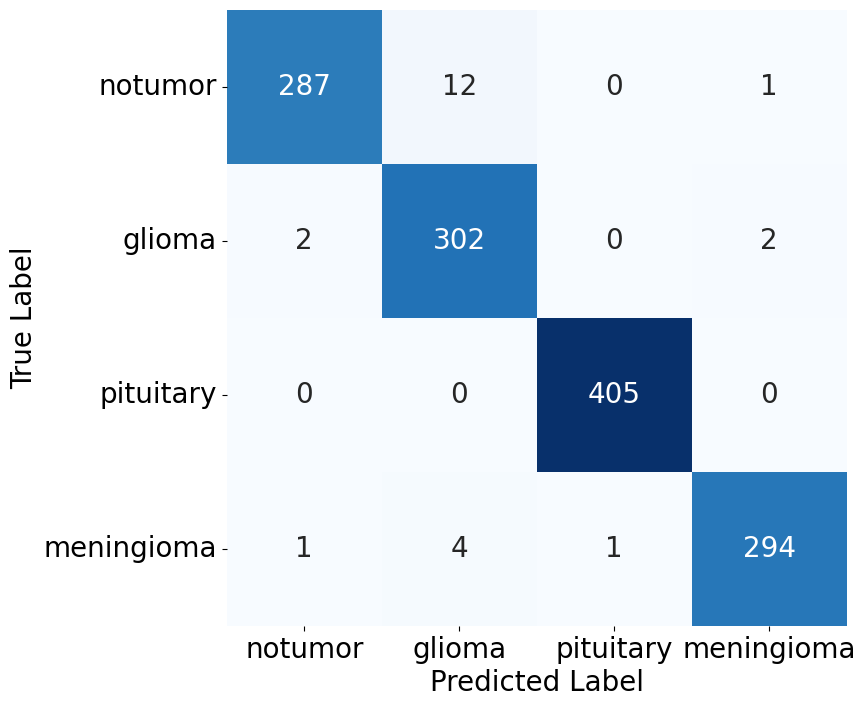

In [ ]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np


# # Get the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(8,8))
# sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()

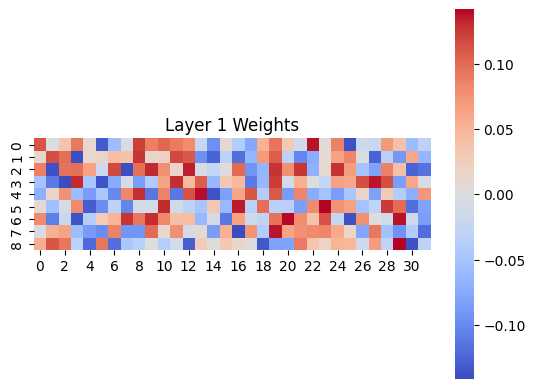

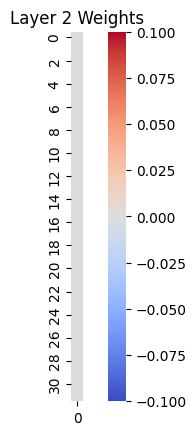

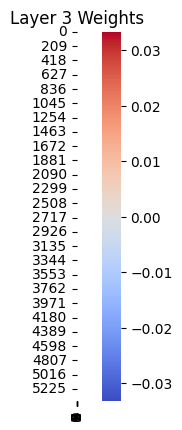

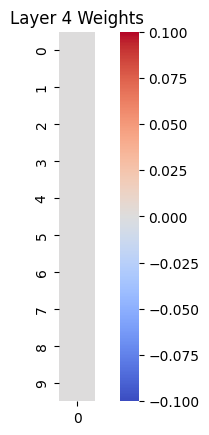

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Define the global model
global_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the global model
global_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Get the weights of the layers
layer1_weights = global_model.layers[0].get_weights()[0][:,:,0,:]
layer2_weights = global_model.layers[0].get_weights()[1]
layer3_weights = global_model.layers[3].get_weights()[0]
layer4_weights = global_model.layers[3].get_weights()[1]

# Draw the parameter heatmap
sns.heatmap(layer1_weights.reshape(9, 32), cmap='coolwarm', square=True)
plt.title('Layer 1 Weights')
plt.show()

sns.heatmap(layer2_weights.reshape(32, 1), cmap='coolwarm', square=True)
plt.title('Layer 2 Weights')
plt.show()

sns.heatmap(layer3_weights, cmap='coolwarm', square=True)
plt.title('Layer 3 Weights')
plt.show()

sns.heatmap(layer4_weights.reshape(10, 1), cmap='coolwarm', square=True)
plt.title('Layer 4 Weights')
plt.show()